In [11]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

# Задаём пути к директориям с эмбеддингами
path_personalitys = '../../data/embeddings/personalities'
path_users = '../../data/embeddings/users'
path_vacancies = '../../data/embeddings/vacancies'

# Функция для загрузки всех эмбеддингов из директории
def load_embeddings_from_directory(path):
    embeddings = []
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if filename.endswith('.npy'):
            # Загрузка файла в формате .npy
            embedding = np.load(file_path)
        elif filename.endswith('.csv'):
            # Загрузка файла в формате .csv
            embedding = np.loadtxt(file_path, delimiter=',')
        else:
            continue  # Пропускаем файлы с неподходящим форматом
        embeddings.append(embedding)
    # Объединяем все эмбеддинги в один массив
    return np.vstack(embeddings) if embeddings else np.array([])

# Загружаем эмбеддинги для кандидатов, вакансий и OCEAN
embeddings_candidates = load_embeddings_from_directory(path_users)
embeddings_vacancies = load_embeddings_from_directory(path_vacancies)
embeddings_ocean = load_embeddings_from_directory(path_personalitys)

# Проверяем размеры считанных массивов
print("Размер эмбеддингов кандидатов:", embeddings_candidates.shape)
print("Размер эмбеддингов вакансий:", embeddings_vacancies.shape)
print("Размер эмбеддингов OCEAN:", embeddings_ocean.shape)

Размер эмбеддингов кандидатов: (8000, 384)
Размер эмбеддингов вакансий: (2277, 384)
Размер эмбеддингов OCEAN: (21, 384)


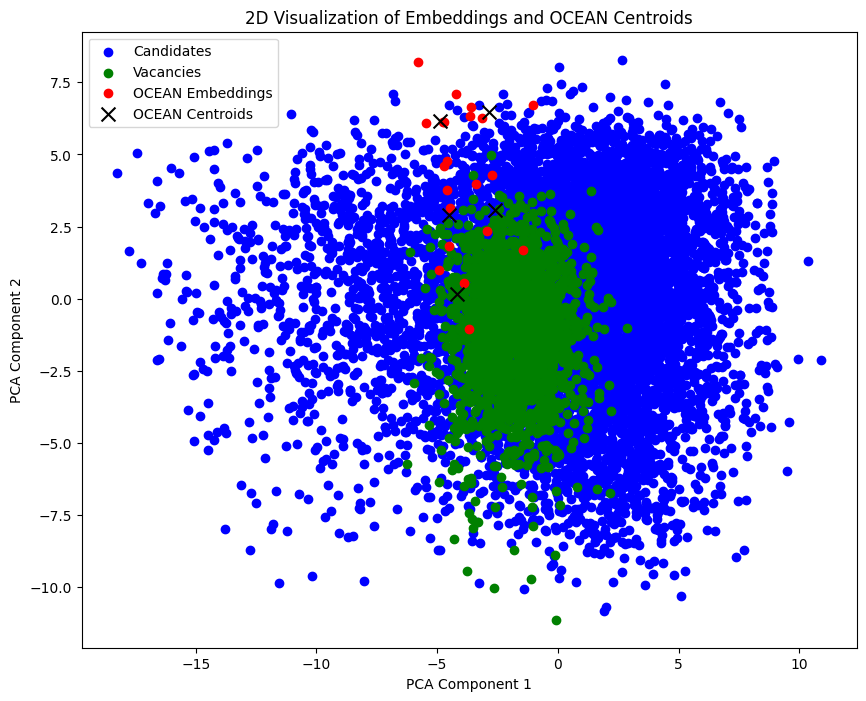

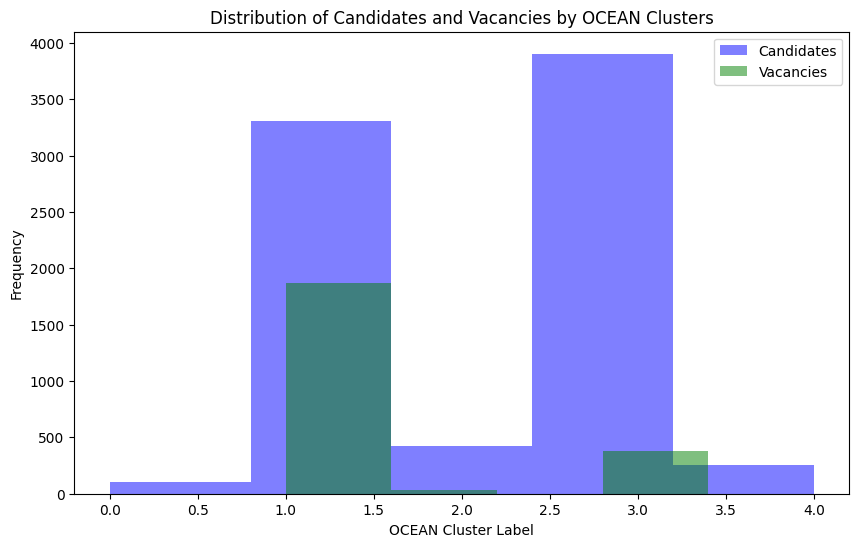

Total Matches Found: 7666543


In [12]:
from sklearn.cluster import KMeans

# Пример данных: эмбеддинги кандидатов, вакансий и OCEAN
# Допустим, что embeddings_candidates, embeddings_vacancies, embeddings_ocean уже заданы
# embeddings_candidates, embeddings_vacancies, embeddings_ocean - это numpy массивы размерностью (n_samples, n_features)

# 1. Нормализуем и применим PCA для уменьшения размерности до 2D
scaler = StandardScaler()
pca = PCA(n_components=2)

# Применяем StandardScaler и PCA по очереди к каждой группе эмбеддингов
embeddings_candidates_2d = pca.fit_transform(scaler.fit_transform(embeddings_candidates))
embeddings_vacancies_2d = pca.transform(scaler.transform(embeddings_vacancies))
embeddings_ocean_2d = pca.transform(scaler.transform(embeddings_ocean))

# Применяем KMeans для нахождения 5 центроидов OCEAN
kmeans_ocean = KMeans(n_clusters=n_ocean_centroids, random_state=42)
kmeans_ocean.fit(embeddings_ocean_2d)
ocean_centroids_2d = kmeans_ocean.cluster_centers_

# 4. Назначение каждого эмбеддинга к ближайшему центроиду
knn_centroids = KNeighborsClassifier(n_neighbors=1)
knn_centroids.fit(ocean_centroids_2d, range(n_ocean_centroids))

# Находим ближайший центроид для каждого кандидата и вакансии
candidate_labels = knn_centroids.predict(embeddings_candidates_2d)
vacancy_labels = knn_centroids.predict(embeddings_vacancies_2d)

# 3. Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_candidates_2d[:, 0], embeddings_candidates_2d[:, 1], color='blue', label='Candidates')
plt.scatter(embeddings_vacancies_2d[:, 0], embeddings_vacancies_2d[:, 1], color='green', label='Vacancies')
plt.scatter(embeddings_ocean_2d[:, 0], embeddings_ocean_2d[:, 1], color='red', label='OCEAN Embeddings')
plt.scatter(ocean_centroids_2d[:, 0], ocean_centroids_2d[:, 1], color='black', marker='x', s=100, label='OCEAN Centroids')
plt.legend()
plt.title("2D Visualization of Embeddings and OCEAN Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# 4. Назначение каждого эмбеддинга к ближайшему центроиду
knn_centroids = KNeighborsClassifier(n_neighbors=1)
knn_centroids.fit(ocean_centroids_2d, range(n_ocean_centroids))

# Находим ближайший центроид для каждого кандидата и вакансии
candidate_labels = knn_centroids.predict(embeddings_candidates_2d)
vacancy_labels = knn_centroids.predict(embeddings_vacancies_2d)

# 5. Нахождение матчей между кандидатами и вакансиями
# Для простоты будем считать матчем пары, находящиеся в одном кластере (ближайший центроид одинаковый)
matches = [(i, j) for i, label_candidate in enumerate(candidate_labels)
                  for j, label_vacancy in enumerate(vacancy_labels) if label_candidate == label_vacancy]

# 6. Построение гистограммы распределения по кластерам
plt.figure(figsize=(10, 6))
plt.hist(candidate_labels, bins=n_ocean_centroids, alpha=0.5, label='Candidates', color='blue')
plt.hist(vacancy_labels, bins=n_ocean_centroids, alpha=0.5, label='Vacancies', color='green')
plt.title("Distribution of Candidates and Vacancies by OCEAN Clusters")
plt.xlabel("OCEAN Cluster Label")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Дополнительно: Выводим информацию о найденных матчах
print(f"Total Matches Found: {len(matches)}")
for match in matches:
    candidate_idx, vacancy_idx = match
    # print(f"Match: Candidate {candidate_idx} - Vacancy {vacancy_idx}")

Epoch [660/1000], Total Loss: 0.0009, Reconstruction Loss: 0.0008, Clustering Loss: 0.0000


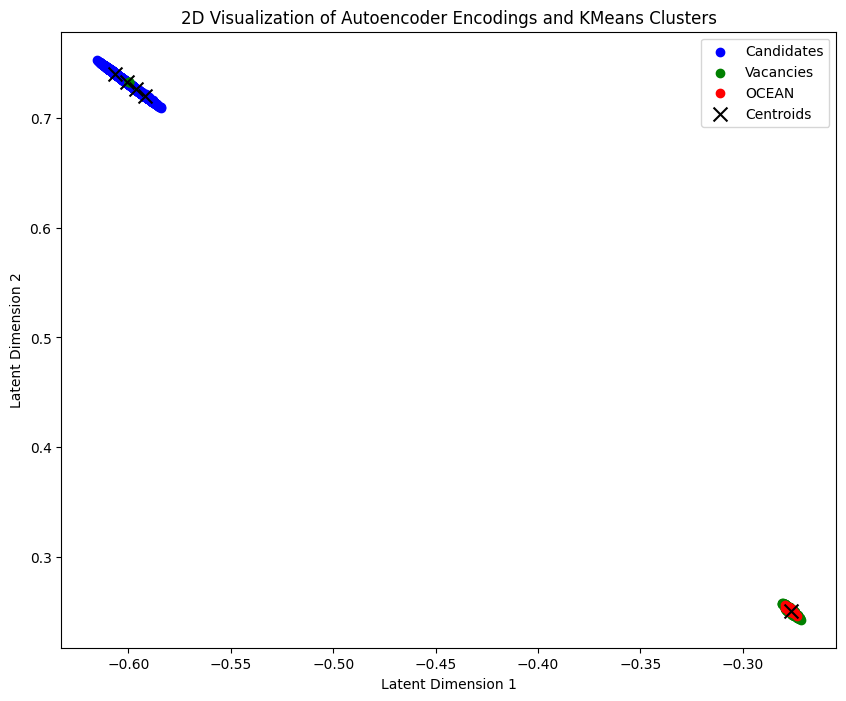

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Parameters
input_dim = embeddings_candidates.shape[1]
latent_dim = 2  # Change to 2D for easier visualization
n_clusters = 5

# Autoencoder Definition
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)  # Latent space
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize Autoencoder and Optimizer
autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training parameters
num_epochs = 1000
batch_size = 64

# Prepare embeddings for training
embeddings = np.vstack([embeddings_candidates, embeddings_vacancies, embeddings_ocean])
embeddings_tensor = torch.FloatTensor(embeddings)

# Training loop with real-time visualization
for epoch in range(num_epochs):
    autoencoder.train()
    
    # Forward pass
    encoded, decoded = autoencoder(embeddings_tensor)
    
    # Calculate reconstruction loss
    reconstruction_loss = criterion(decoded, embeddings_tensor)
    
    # Apply KMeans on latent space representations
    encoded_np = encoded.detach().numpy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_assignments = kmeans.fit_predict(encoded_np)
    centroids = kmeans.cluster_centers_
    
    # Initialize clustering loss as a scalar
    clustering_loss = 0.0

    # Calculate clustering loss (distance of points to their centroids)
    for i, centroid in enumerate(centroids):
        cluster_points = encoded[torch.tensor(cluster_assignments) == i]
        if len(cluster_points) > 0:
            centroid_tensor = torch.FloatTensor(centroid).to(cluster_points.device)
            clustering_loss += torch.sum((cluster_points - centroid_tensor) ** 2)

    # Average over the number of points to get a mean clustering loss
    clustering_loss /= len(embeddings_tensor)
    
    # Total loss: Reconstruction + Clustering
    total_loss = reconstruction_loss + clustering_loss

    # Backpropagation
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Logging
    if epoch % 10 == 0:
        clear_output(wait=True)  # Clear the previous plot
        print(f"Epoch [{epoch}/{num_epochs}], Total Loss: {total_loss.item():.4f}, "
              f"Reconstruction Loss: {reconstruction_loss.item():.4f}, "
              f"Clustering Loss: {clustering_loss.item():.4f}")
        
        # Visualize in 2D
        plt.figure(figsize=(10, 8))
        plt.scatter(encoded_np[:len(embeddings_candidates), 0], encoded_np[:len(embeddings_candidates), 1], 
                    color='blue', label='Candidates')
        plt.scatter(encoded_np[len(embeddings_candidates):len(embeddings_candidates) + len(embeddings_vacancies), 0],
                    encoded_np[len(embeddings_candidates):len(embeddings_candidates) + len(embeddings_vacancies), 1],
                    color='green', label='Vacancies')
        plt.scatter(encoded_np[-len(embeddings_ocean):, 0], encoded_np[-len(embeddings_ocean):, 1], 
                    color='red', label='OCEAN')
        plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')
        plt.legend()
        plt.title("2D Visualization of Autoencoder Encodings and KMeans Clusters")
        plt.xlabel("Latent Dimension 1")
        plt.ylabel("Latent Dimension 2")
        plt.show()
